# OpenStreetMap Test

bbox로 맵을 다운 받은 경우 4개의 좌표가 필요한데 입력 순서는 \
latitude :  bottom, top\
longitude : left, right\
minlat => bottom\
maxlat => top\
minlong => left\
maxlong => right

참조 :\
[GeoMakie.jl/examples/specialized/osmmakie.jl] https://github.com/MakieOrg/GeoMakie.jl/blob/a120e51876b6fdc021c919d29eeaf5934576b038/examples/specialized/osmmakie.jl

[MakieOrg/OSMMakie.jl]\
https://github.com/MakieOrg/OSMMakie.jl

In [1]:
import Logging
Logging.disable_logging(Logging.Warn)

LogLevel(1001)

In [2]:
using Graphs
using HTTP
using JSON
using LightOSM
using LightXML
using SparseArrays
using Random

In [3]:
using OSMMakie
using CairoMakie
using GeoMakie

In [4]:
function wait_for_overpass()
    count = 0
    is_available = true
    while !LightOSM.is_overpass_server_availabile()
        if count == 7 is_available = false end
        count == 7 && break
        count += 1
        @info "Waiting for overpass server..."
        sleep(5*count)        
    end
    return is_available
end

wait_for_overpass (generic function with 1 method)

In [5]:
area = (
    minlat = 37.5544,  # bottom
    minlon = 126.9597, # left
    maxlat = 37.5774,  # top
    maxlon = 126.9999, # right
)
autolimitaspect = map_aspect(area.minlat, area.maxlat)

1.2615866716466604

In [6]:
filenames = ["map.osm","map.json"]
formats = [:osm, :json]
for (filename, format) in zip(filenames, formats)
    try
        wait_for_overpass()
        data = download_osm_network(:bbox; # rectangular area
            area...,
            network_type = :drive,
            metadata = false,
            download_format=format,
            save_to_file_location=filename
            )
    catch err
        # Sometimes gets HTTP.ExceptionRequest.StatusError in tests
        # due to connection to overpass
        !isa(err, HTTP.ExceptionRequest.StatusError) && rethrow()
    end
end

### Load Street

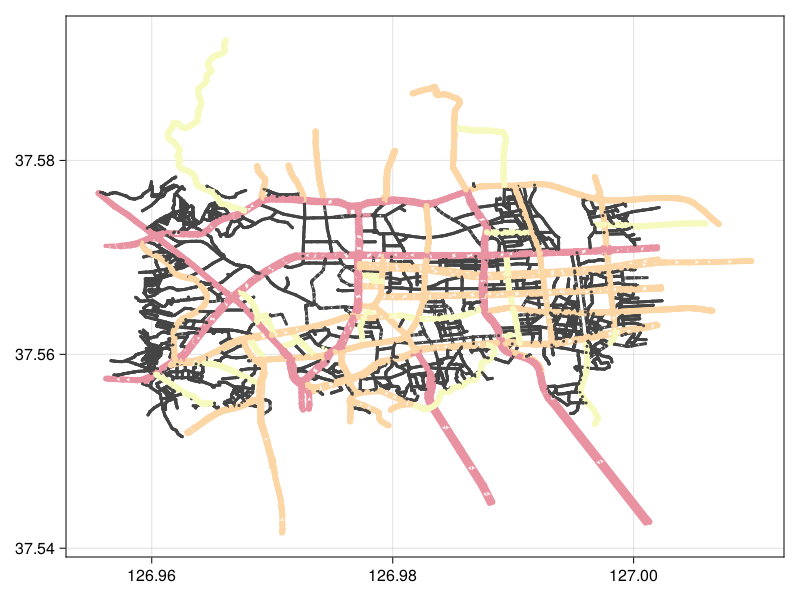

In [7]:
osm = graph_from_file("map.json";
    graph_type = :light, # SimpleDiGraph
    weight_type = :distance )

fig, ax, plot = osmplot(osm) #,axis = (; autolimitaspect))

In [8]:
filenames = ["map_bds.osm","map_bds.json"]
formats = [:osm, :json]
for (filename, format) in zip(filenames, formats)
    try
        wait_for_overpass()
        data = download_osm_buildings(:bbox; # rectangular area
            area...,
            metadata = true,
            download_format=format,
            save_to_file_location=filename
            );
    catch err
        # Sometimes gets HTTP.ExceptionRequest.StatusError in tests
        # due to connection to overpass
        !isa(err, HTTP.ExceptionRequest.StatusError) && rethrow()
    end
end

### load as Buildings Dict

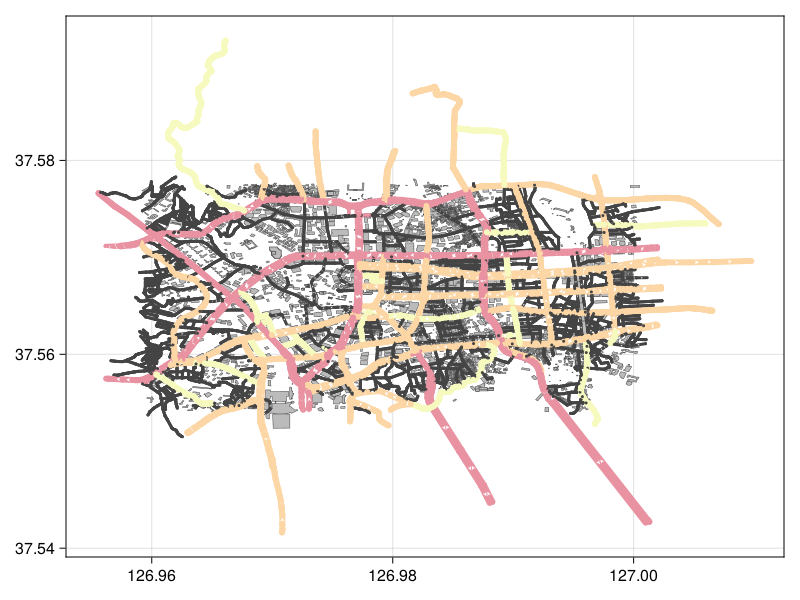

In [9]:
buildings = buildings_from_file("map_bds.json")
fig, ax, plot = osmplot(osm;buildings)